<a href="https://colab.research.google.com/github/HoaxBlade/Adversarial-attack-notebook/blob/main/Adversarial%20attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
def load_image(path, size=(224, 224)):
    img = Image.open(path).convert('RGB').resize(size)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)  # shape: (1, 3, H, W)


In [ ]:
def denoise(image_tensor):
    # Denoising using a median filter implemented in PyTorch
    unfolded = F.unfold(image_tensor, kernel_size=3, padding=1)
    # Correctly reshape for median calculation
    unfolded = unfolded.view(image_tensor.size(0), image_tensor.size(1), 9, -1)
    # Median along the 'kernel' dimension
    median = torch.median(unfolded, dim=2)[0]
    # Reshape back to image format
    denoised = median.view(image_tensor.size())
    return denoised

In [ ]:
def adversarial_attack(original, target, eps=0.05, steps=300, alpha=0.01):
    x_adv = original.clone().detach()
    x_adv.requires_grad = True

    for step in range(steps):
        # Forward
        denoised = denoise(x_adv)
        loss = F.mse_loss(denoised, target)

        # Backward
        loss.backward()

        # Update step
        with torch.no_grad():
            x_adv = x_adv + alpha * x_adv.grad.sign()
            x_adv = torch.max(torch.min(x_adv, original + eps), original - eps)
            x_adv = torch.clamp(x_adv, 0, 1)

        # Re-prepare for next step
        x_adv = x_adv.detach()
        x_adv.requires_grad = True

    return x_adv


In [ ]:
def show_image(tensor_img, title=""):
    np_img = tensor_img.squeeze().detach().cpu().numpy().transpose(1,2,0)
    plt.imshow(np.clip(np_img, 0, 1))
    plt.title(title)
    plt.axis('off')

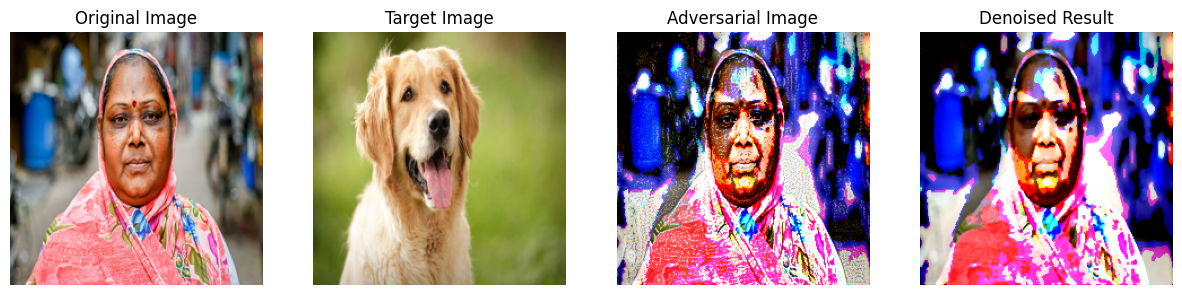

In [ ]:
original = load_image("lena.jpg")
target = load_image("dog.jpg")

adv_image = adversarial_attack(original, target, eps=0.3, steps=300, alpha=0.01)
denoised_result = denoise(adv_image)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
show_image(original, "Original Image")
plt.subplot(1, 4, 2)
show_image(target, "Target Image")
plt.subplot(1, 4, 3)
show_image(adv_image, "Adversarial Image")
plt.subplot(1, 4, 4)
show_image(denoised_result, "Denoised Result")
plt.show()

In [ ]:
print("MSE to Target:", F.mse_loss(denoised_result, target))
print("MSE to Original:", F.mse_loss(denoised_result, original))

MSE to Target: tensor(0.2535, grad_fn=<MseLossBackward0>)
MSE to Original: tensor(0.0649, grad_fn=<MseLossBackward0>)


Step 0: multi-layer perceptual loss = 47.9881
Step 50: multi-layer perceptual loss = 7.7905
Step 100: multi-layer perceptual loss = 5.0029
Step 150: multi-layer perceptual loss = 4.4568
Step 200: multi-layer perceptual loss = 4.1955
Step 250: multi-layer perceptual loss = 4.1038
Step 300: multi-layer perceptual loss = 4.0215
Step 350: multi-layer perceptual loss = 4.0089
Step 400: multi-layer perceptual loss = 3.9589
Step 450: multi-layer perceptual loss = 3.9375
Step 499: multi-layer perceptual loss = 3.9618


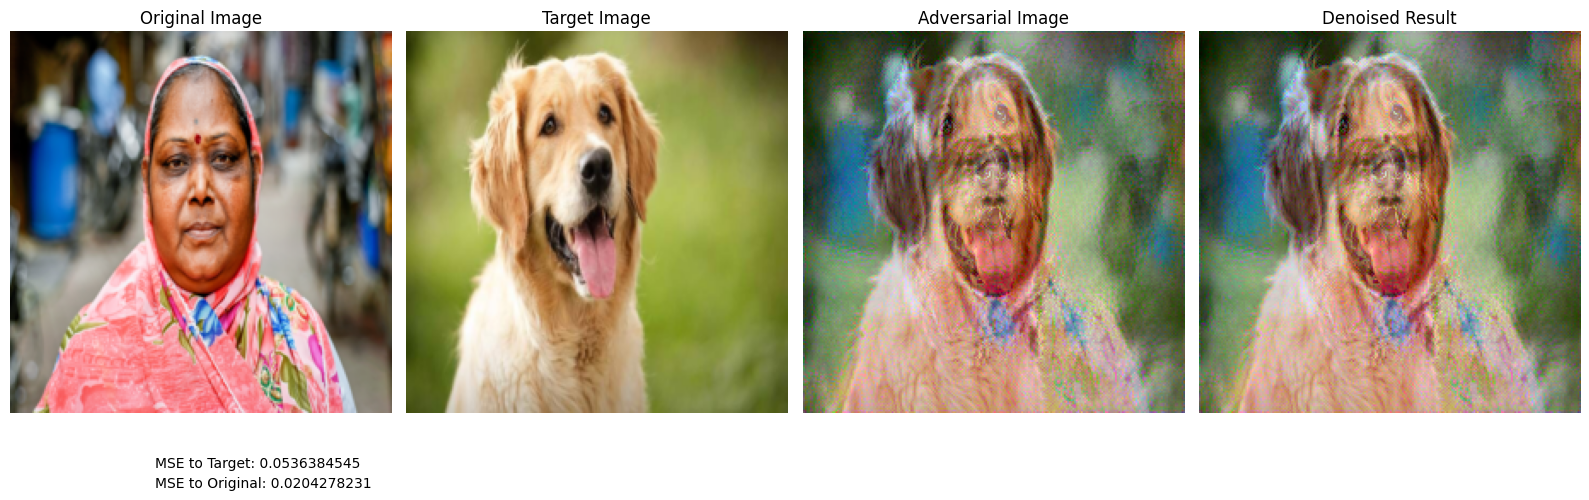

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------- #
#         Preprocessing         #
# ----------------------------- #

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

def normalize(img):
    return (img - imagenet_mean) / imagenet_std

def load_image(path):
    img = Image.open(path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    return img

# ----------------------------- #
#      Perceptual VGG Model     #
# ----------------------------- #

class VGGPerceptual(nn.Module):
    def __init__(self, layers=('3', '8', '17', '26')):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features[:max(map(int, layers))+1]
        self.selected_layers = layers
        self.model = vgg.eval()
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.selected_layers:
                features.append(x)
        return features

perceptual_model = VGGPerceptual().to(device)

# ----------------------------- #
#         Dummy Denoiser        #
# ----------------------------- #

def denoise(img):
    return torch.clamp(img, 0, 1)  # placeholder for your Bezier denoiser

# ----------------------------- #
#     Adversarial Attack Core   #
# ----------------------------- #

def adversarial_attack(original, target, eps=0.2, alpha=0.02, steps=500):
    original = original.detach()
    x_adv = original.clone().detach().requires_grad_(True).to(device)

    target_feats = perceptual_model(normalize(target))

    optimizer = torch.optim.Adam([x_adv], lr=alpha)

    for step in range(steps):
        optimizer.zero_grad()

        adv_feats = perceptual_model(normalize(x_adv))

        perceptual_loss = sum([nn.functional.mse_loss(a, t) for a, t in zip(adv_feats, target_feats)])
        perceptual_loss.backward()
        optimizer.step()

        with torch.no_grad():
            perturbation = torch.clamp(x_adv - original, -eps, eps)
            x_adv[:] = torch.clamp(original + perturbation, 0, 1)

        if step % 50 == 0 or step == steps - 1:
            print(f"Step {step}: multi-layer perceptual loss = {perceptual_loss.item():.4f}")

    return x_adv.detach()

# ----------------------------- #
#        Image Comparison       #
# ----------------------------- #

def show_results(original, target, adv, denoised):
    def to_numpy(t):
        return np.transpose(t.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

    mse_target = nn.functional.mse_loss(denoised, target).item()
    mse_original = nn.functional.mse_loss(denoised, original).item()

    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    titles = ['Original Image', 'Target Image', 'Adversarial Image', 'Denoised Result']
    images = [original, target, adv, denoised]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(to_numpy(img))
        ax.set_title(title)
        ax.axis('off')

    plt.figtext(0.1, 0.01, f"MSE to Target: {mse_target:.10f}", fontsize=10)
    plt.figtext(0.1, -0.03, f"MSE to Original: {mse_original:.10f}", fontsize=10)
    plt.tight_layout()
    plt.show()

# ----------------------------- #
#         Run Everything        #
# ----------------------------- #

original = load_image("lena.jpg")
target = load_image("dog.jpg")

adv_image = adversarial_attack(original, target, eps=0.2, alpha=0.02, steps=500)
denoised_result = denoise(adv_image)

show_results(original, target, adv_image, denoised_result)


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image

# Load an image as tensor
def load_image(path, size=(224, 224)):
    image = Image.open(path).convert('RGB')
    image = image.resize(size, Image.BICUBIC)
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image).unsqueeze(0)

# Save a tensor image to file
def save_image(tensor, path):
    image = tensor.squeeze().detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0)) * 255
    image = np.clip(image, 0, 255).astype(np.uint8)
    Image.fromarray(image).save(path)

# VGG19-based perceptual model
class VGGPerceptual(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features[:21]
        for param in vgg.parameters():
            param.requires_grad = False
        self.model = vgg.eval()

    def forward(self, x):
        return self.model(x)

# Adversarial attack using perceptual loss
def adversarial_attack(original, target, eps=0.1, steps=300, alpha=0.01):
    perceptual_model = VGGPerceptual().to(original.device)
    x_adv = original.clone().detach().requires_grad_(True)

    with torch.no_grad():
        target_feats = perceptual_model(target)

    optimizer = torch.optim.Adam([x_adv], lr=alpha)
    loss_fn = nn.MSELoss()

    for _ in range(steps):
        optimizer.zero_grad()
        adv_feats = perceptual_model(x_adv)
        loss = loss_fn(adv_feats, target_feats)
        loss.backward()
        grad = x_adv.grad.data
        x_adv.data = x_adv.data + alpha * grad.sign()
        x_adv.data = torch.max(torch.min(x_adv.data, original + eps), original - eps)
        x_adv.data = torch.clamp(x_adv.data, 0, 1)

    return x_adv.detach()

# Bezier interpolation-based denoising
def bezier_denoise(image_tensor):
    image_np = image_tensor.squeeze().detach().cpu().numpy()
    image_np = np.transpose(image_np, (1, 2, 0)) * 255
    image_np = np.clip(image_np, 0, 255).astype(np.uint8)

    def bezier_interpolate(p0, p1, p2, p3, t):
        return ((1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 +
                3 * (1 - t) * t**2 * p2 + t**3 * p3)

    def get_control_points(window):
        flat = window.reshape(-1)
        diffs = np.abs(flat - flat[4])
        sorted_idx = np.argsort(diffs)
        selected = flat[sorted_idx[:4]]
        return selected

    def denoise_channel(channel):
        padded = np.pad(channel, ((1, 1), (1, 1)), mode='edge')
        denoised = np.copy(channel)
        for i in range(1, channel.shape[0] + 1):
            for j in range(1, channel.shape[1] + 1):
                window = padded[i-1:i+2, j-1:j+2]
                if window[1, 1] in [0, 255]:  # fixed impulse noise
                    ctrl_pts = get_control_points(window)
                    np_vals = [bezier_interpolate(*ctrl_pts, t)
                               for t in np.linspace(0, 1, 10)]
                    denoised[i-1, j-1] = np.mean(np_vals)
        return denoised

    denoised_channels = [denoise_channel(image_np[:, :, c]) for c in range(3)]
    denoised_np = np.stack(denoised_channels, axis=2)
    denoised_np = np.clip(denoised_np / 255.0, 0, 1)
    denoised_tensor = torch.tensor(np.transpose(denoised_np, (2, 0, 1)), dtype=torch.float32).unsqueeze(0)
    return denoised_tensor

# --- Run Full Pipeline ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load images
image_size = (224, 224)
original = load_image("lena.jpg", size=image_size).to(device)
target = load_image("dog.jpg", size=image_size).to(device)


# Generate adversarial image
adv_image = adversarial_attack(original, target, eps=0.2, alpha=0.02, steps=500)

# Denoise with Bezier curve-based interpolation
denoised_image = bezier_denoise(adv_image)

# Save final outputs
save_image(original, "original.jpg")
save_image(target, "target.jpg")
save_image(adv_image, "adv.jpg")
save_image(denoised_image, "denoised.jpg")


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and resize image
def load_image(path, size=(224, 224)):
    img = Image.open(path).convert('RGB').resize(size, Image.BICUBIC)
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(img).unsqueeze(0).to(device)

# Simple denoising using 3x3 median filter
def denoise(image_tensor):
    unfolded = F.unfold(image_tensor, kernel_size=3, padding=1)
    unfolded = unfolded.view(image_tensor.size(0), image_tensor.size(1), 9, -1)
    median = torch.median(unfolded, dim=2)[0]
    return median.view(image_tensor.size())

# VGG Feature Extractor (for perceptual loss)
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:16]
        for param in vgg.parameters():
            param.requires_grad = False
        self.model = vgg.eval().to(device)

    def forward(self, x):
        return self.model(x)

# Adversarial attack with perceptual loss (VGG-based)
def adversarial_attack(original, target, eps=0.4, alpha=0.05, steps=500):
    x_adv = original.clone().detach().to(device)
    x_adv.requires_grad = True

    perceptual_model = VGGFeatures()
    with torch.no_grad():
        target_feats = perceptual_model(target)

    optimizer = torch.optim.Adam([x_adv], lr=alpha)
    loss_history = []

    for step in range(steps):
        optimizer.zero_grad()
        adv_feats = perceptual_model(x_adv)
        loss = F.mse_loss(adv_feats, target_feats)
        loss.backward()
        optimizer.step()

        # Project perturbation
        perturbation = torch.clamp(x_adv - original, -eps, eps)
        x_adv.data = torch.clamp(original + perturbation, 0, 1)

        loss_history.append(loss.item())

    return x_adv.detach(), loss_history

# Show original, target, adv, denoised — and MSEs
def show_results(original, target, adv, denoised):
    def to_numpy(t):
        return np.transpose(t.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

    mse_target = F.mse_loss(denoised, target).item()
    mse_original = F.mse_loss(denoised, original).item()

    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    titles = ['Original Image', 'Target Image', 'Adversarial Image', 'Denoised Result']
    images = [original, target, adv, denoised]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(to_numpy(img))
        ax.set_title(title)
        ax.axis('off')

    plt.figtext(0.1, 0.01, f"MSE to Target: {mse_target:.10f}", fontsize=10)
    plt.figtext(0.1, -0.03, f"MSE to Original: {mse_original:.10f}", fontsize=10)
    plt.tight_layout()
    plt.show()

# === Run the attack ===
image_size = (224, 224)
original = load_image("lena.jpg", size=image_size)
target = load_image("dog.jpg", size=image_size)

# Generate adversarial image and get loss history
adv_image, loss_history = adversarial_attack(original, target, eps=0.4, alpha=0.05, steps=500)

# Denoise the adversarial image
denoised_result = denoise(adv_image)

# Show all results
show_results(original, target, adv_image, denoised_result)

# Plot the perceptual loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Perceptual Loss (VGG MSE)')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Perceptual Loss During Adversarial Attack")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 158MB/s]
